# The Phillipcurve

# skriv hvad spørgsmålet er og hvad modelen går ud på*

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `dataproject.py` file includes a function which can be used multiple times in this notebook.

In [3]:
!pip install matplotlib-venn

Imports and set magics:

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib_venn import venn2
import pandas_datareader 
from dstapi import DstApi

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject


ModuleNotFoundError: No module named 'dataproject'

# Read and clean data

# Unemployment data

We start out by importing the uneployment data (seasonally adjusted). We import it by using API, we therefore import the data directly for DST. 

In [2]:
# We create an dst api **object** that will allow us to interact with the DST server. 
AUS = DstApi('AUS09') 

# A quick overview of the available data
tabsum = AUS.tablesummary(language='en')
display(tabsum)

Table AUS09: Unemployment indicator by type of benefits, seasonal adjustment and actual figures and time
Last update: 2024-03-27T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,YDELSESTYPE,3,TOT,Gross unemployment,LKM,Unemployed recipients of social assistance,False
1,SAESONFAK,4,9,Seasonally adjusted figures in percent of the ...,24,Enumerated actual figures,False
2,Tid,206,2007M01,2007M01,2024M02,2024M02,True


In [3]:
# The available values for a each variable: 
for variable in tabsum['variable name']:
    print(variable+':')
    display(AUS.variable_levels(variable, language='en'))

YDELSESTYPE:


,id,text
0,TOT,Gross unemployment
1,LDM,Unemployed recipients of unemployment benefits
2,LKM,Unemployed recipients of social assistance


SAESONFAK:


,id,text
0,9,Seasonally adjusted figures in percent of the ...
1,10,Seasonally adjusted
2,22,Enumerated actual figures in percent of the l...
3,24,Enumerated actual figures


Tid:


,id,text
0,2007M01,2007M01
1,2007M02,2007M02
2,2007M03,2007M03
3,2007M04,2007M04
4,2007M05,2007M05
...,...,...
201,2023M10,2023M10
202,2023M11,2023M11
203,2023M12,2023M12
204,2024M01,2024M01


In [4]:
# The _define_base_params -method gives us a nice template (selects all available data)
params = AUS._define_base_params(language='en')
params

{'table': 'aus09',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'YDELSESTYPE', 'values': ['*']},
  {'code': 'SAESONFAK', 'values': ['*']},
  {'code': 'Tid', 'values': ['*']}]}

In [5]:
# We define what we want the dataset to contain
params = {'table': 'aus09',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'YDELSESTYPE', 'values': ['TOT']},
  {'code': 'SAESONFAK', 'values': ['9']},
  {'code': 'Tid', 'values': ['*']}]}

In [6]:
# We load the data from dst via the api using the options specified in the param dictionary 
unemployment = AUS.get_data(params=params)
unemployment.head(5)

,YDELSESTYPE,SAESONFAK,TID,INDHOLD
0,Gross unemployment,Seasonally adjusted figures in percent of the ...,2020M04,5.2
1,Gross unemployment,Seasonally adjusted figures in percent of the ...,2020M09,4.8
2,Gross unemployment,Seasonally adjusted figures in percent of the ...,2021M02,4.5
3,Gross unemployment,Seasonally adjusted figures in percent of the ...,2021M03,4.3
4,Gross unemployment,Seasonally adjusted figures in percent of the ...,2022M02,2.4


In [7]:
# We sort the data so it is in chronological order
unemployment = unemployment.sort_values(by='TID')
print(unemployment)

            YDELSESTYPE                                          SAESONFAK  \
113  Gross unemployment  Seasonally adjusted figures in percent of the ...   
168  Gross unemployment  Seasonally adjusted figures in percent of the ...   
114  Gross unemployment  Seasonally adjusted figures in percent of the ...   
81   Gross unemployment  Seasonally adjusted figures in percent of the ...   
185  Gross unemployment  Seasonally adjusted figures in percent of the ...   
..                  ...                                                ...   
31   Gross unemployment  Seasonally adjusted figures in percent of the ...   
39   Gross unemployment  Seasonally adjusted figures in percent of the ...   
5    Gross unemployment  Seasonally adjusted figures in percent of the ...   
10   Gross unemployment  Seasonally adjusted figures in percent of the ...   
49   Gross unemployment  Seasonally adjusted figures in percent of the ...   

         TID INDHOLD  
113  2007M01     4.3  
168  2007M02     

In [8]:
# We reset the index
unemployment.reset_index(drop=True, inplace=True)
print(unemployment)

            YDELSESTYPE                                          SAESONFAK  \
0    Gross unemployment  Seasonally adjusted figures in percent of the ...   
1    Gross unemployment  Seasonally adjusted figures in percent of the ...   
2    Gross unemployment  Seasonally adjusted figures in percent of the ...   
3    Gross unemployment  Seasonally adjusted figures in percent of the ...   
4    Gross unemployment  Seasonally adjusted figures in percent of the ...   
..                  ...                                                ...   
201  Gross unemployment  Seasonally adjusted figures in percent of the ...   
202  Gross unemployment  Seasonally adjusted figures in percent of the ...   
203  Gross unemployment  Seasonally adjusted figures in percent of the ...   
204  Gross unemployment  Seasonally adjusted figures in percent of the ...   
205  Gross unemployment  Seasonally adjusted figures in percent of the ...   

         TID INDHOLD  
0    2007M01     4.3  
1    2007M02     

In [9]:
# We delete the last two rows
unemployment = unemployment[:-2]

# We drop the variables "YDELSESTYPE" and "SAESONFAK"
unemployment = unemployment.drop(columns=['YDELSESTYPE', 'SAESONFAK'])

# We rename "TID" and "INDHOLD"
unemployment.rename(columns = {"TID": "year_month","INDHOLD": "unemployment"},  inplace =True)
print(unemployment)

    year_month unemployment
0      2007M01          4.3
1      2007M02          4.1
2      2007M03          3.9
3      2007M04          3.9
4      2007M05          3.8
..         ...          ...
199    2023M08          2.8
200    2023M09          2.8
201    2023M10          2.8
202    2023M11          2.9
203    2023M12          2.9

[204 rows x 2 columns]


We now have a dataset for unemployment that goes from primo 2007 to ultimo 2023

# Consumer price index

We import data for consumer price index by downloading the dataset from DST as a .csv file. 

In [10]:
import os 

# Using assert to check that paths exist on computer.
assert os.path.isdir('data/')
assert os.path.isfile('data/PRIS113.csv')

# Print everything in data
os.listdir('data/')

['.DS_Store', 'PRIS113.csv']

In [11]:
# we save the dataset as "data" 
PRIS = 'data/PRIS113.csv'

# we skip the first 322 rows
index = pd.read_csv(PRIS, sep=';', skiprows=299)
index.head(5)


,2004M12,82.6
0,2005M01,82.4
1,2005M02,83.2
2,2005M03,83.7
3,2005M04,84.1
4,2005M05,84.1


In [12]:
# We delete the last two rows
index = index[:-2]
index.tail(5)

,2004M12,82.6
223,2023M08,117.7
224,2023M09,117.4
225,2023M10,117.7
226,2023M11,117.3
227,2023M12,116.7


Now our dataset goes fromn 2005M01 to 2023M12

In [13]:
# We rename our variables
index.rename(columns = {"2004M12": "year_month","82.6": "cp_index"},  inplace =True)
print(index)

    year_month  cp_index
0      2005M01      82.4
1      2005M02      83.2
2      2005M03      83.7
3      2005M04      84.1
4      2005M05      84.1
..         ...       ...
223    2023M08     117.7
224    2023M09     117.4
225    2023M10     117.7
226    2023M11     117.3
227    2023M12     116.7

[228 rows x 2 columns]


In [14]:
# We calculate the inflation by comparing the cp_index a given month with the same month a year ago
index['inflation'] = (index['cp_index'] - index['cp_index'].shift(12)) / index['cp_index'].shift(12) * 100

# we print and delete the year 2005, since this would be equal to zero 
index = index.iloc[12:]
print(index)

    year_month  cp_index  inflation
12     2006M01      84.2   2.184466
13     2006M02      85.0   2.163462
14     2006M03      85.3   1.911589
15     2006M04      85.7   1.902497
16     2006M05      85.8   2.021403
..         ...       ...        ...
223    2023M08     117.7   2.436902
224    2023M09     117.4   0.859107
225    2023M10     117.7   0.085034
226    2023M11     117.3   0.600343
227    2023M12     116.7   0.690250

[216 rows x 3 columns]


Our dataset goes from primo 2006 to ultimo 2023

In [15]:
# Now we want to create a variable for the expected inflation. The expected inflation is the inflation the given month a year prior. 
index['exp_inflation'] = index['inflation'].shift(12)

# we print and delete the year 2006, since this would be equal to zero 
index = index.iloc[12:]
print(index)

    year_month  cp_index  inflation  exp_inflation
24     2007M01      85.7   1.781473       2.184466
25     2007M02      86.6   1.882353       2.163462
26     2007M03      87.0   1.992966       1.911589
27     2007M04      87.1   1.633606       1.902497
28     2007M05      87.3   1.748252       2.021403
..         ...       ...        ...            ...
223    2023M08     117.7   2.436902       8.909953
224    2023M09     117.4   0.859107      10.018904
225    2023M10     117.7   0.085034      10.112360
226    2023M11     117.3   0.600343       8.870215
227    2023M12     116.7   0.690250       8.724203

[204 rows x 4 columns]


In [16]:
# Since the index now starts at 24 we will reset it 
index.reset_index(drop=True, inplace=True)
print(index)

    year_month  cp_index  inflation  exp_inflation
0      2007M01      85.7   1.781473       2.184466
1      2007M02      86.6   1.882353       2.163462
2      2007M03      87.0   1.992966       1.911589
3      2007M04      87.1   1.633606       1.902497
4      2007M05      87.3   1.748252       2.021403
..         ...       ...        ...            ...
199    2023M08     117.7   2.436902       8.909953
200    2023M09     117.4   0.859107      10.018904
201    2023M10     117.7   0.085034      10.112360
202    2023M11     117.3   0.600343       8.870215
203    2023M12     116.7   0.690250       8.724203

[204 rows x 4 columns]


Our dataset now goes from primo 2007 to ultimo 2023, just as the unemployment data

# Merge the two datasets

We now have a dataset for unemployment that consist of 204 rows and two variables, and we have a dataset for the consumer price index that also contain 204 rows but with four variables. 

The last thing we want to do is to merge the two datasets. 

In [17]:
# We merge the two datasets
final_dataset = pd.merge(index, unemployment, on="year_month")
print(final_dataset)

    year_month  cp_index  inflation  exp_inflation unemployment
0      2007M01      85.7   1.781473       2.184466          4.3
1      2007M02      86.6   1.882353       2.163462          4.1
2      2007M03      87.0   1.992966       1.911589          3.9
3      2007M04      87.1   1.633606       1.902497          3.9
4      2007M05      87.3   1.748252       2.021403          3.8
..         ...       ...        ...            ...          ...
199    2023M08     117.7   2.436902       8.909953          2.8
200    2023M09     117.4   0.859107      10.018904          2.8
201    2023M10     117.7   0.085034      10.112360          2.8
202    2023M11     117.3   0.600343       8.870215          2.9
203    2023M12     116.7   0.690250       8.724203          2.9

[204 rows x 5 columns]


## Explore each data set

In order to be able to **explore the raw data**, you may provide **static** and **interactive plots** to show important developments 

**Interactive plot** :

In [18]:
def plot_func():
    # Function that operates on data set
    pass

widgets.interact(plot_func, 
    # Let the widget interact with data through plot_func()    
); 


interactive(children=(Output(),), _dom_classes=('widget-interact',))

Explain what you see when moving elements of the interactive plot around. 

# Merge data sets

Now you create combinations of your loaded data sets. Remember the illustration of a (inner) **merge**:

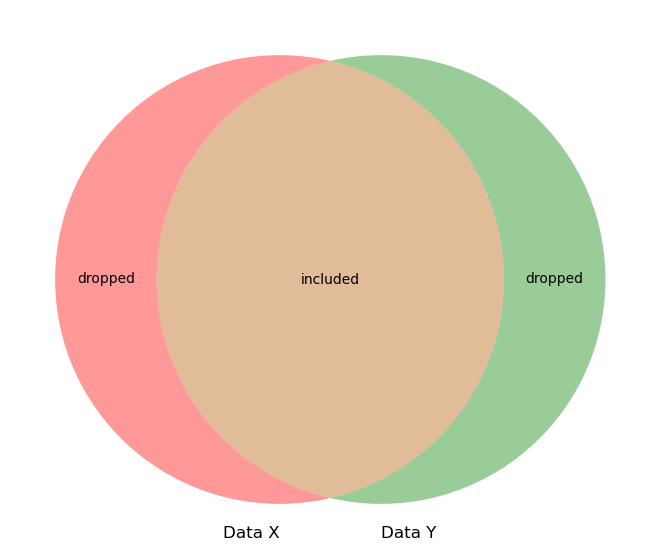

In [19]:
plt.figure(figsize=(15,7))
v = venn2(subsets = (4, 4, 10), set_labels = ('Data X', 'Data Y'))
v.get_label_by_id('100').set_text('dropped')
v.get_label_by_id('010').set_text('dropped' )
v.get_label_by_id('110').set_text('included')
plt.show()

Here we are dropping elements from both data set X and data set Y. A left join would keep all observations in data X intact and subset only from Y. 

Make sure that your resulting data sets have the correct number of rows and columns. That is, be clear about which observations are thrown away. 

**Note:** Don't make Venn diagrams in your own data project. It is just for exposition. 

# Analysis

To get a quick overview of the data, we show some **summary statistics** on a meaningful aggregation. 

MAKE FURTHER ANALYSIS. EXPLAIN THE CODE BRIEFLY AND SUMMARIZE THE RESULTS.

# Conclusion

ADD CONCISE CONLUSION.